In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
#sns.set_context("poster")


In [2]:
# XGBoost is not included in the Anaconda distribution (yet... )
# Therefore you need to install it first
#pip install xgboost
# or
# ! sudo pip install xgboost
# or
# ! pip install --upgrade xgboost
# with sudo if you don't have admin privilegis 
# in a Mac remember that you have to install Xcode and accept the license

from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

from sklearn import preprocessing

import xgboost as xgb

<h1>XGBoost</h1>

XGBoost stands for eXtreme Gradient Boosting. 
<blockquote>
    The name XGBoost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use XGBoost.
    Tianqui Chen, on Quora.com (tre creator of XGBoost)
</blockquote>

XGBoosst is an implementation of Gradient Boosting Machines created by Tianqui Chen for his PhD thesis and now expanded with contributions from many developers. 

If you are interested in the story of XGBoost, Tianqui Chen explains it in the tutorial <i>Story and Lessons Behind the Evolution of XGBoost</i>. 

XGBoost needs to be downloaded and installed in your computer (if you have a Mac you need to download XCode - the Apple development suite - and accept the license agreement first). It has interfaces to many languages besides Python, such as R, Julia, C++, Scala, Java and JVM languages, etc ... XGBoost is distributed under the Apache-2 license. 

XGBoost is built with a cloud platform focus in mind. In fact, AWS, Azure and Google Cloud host implementations of XGBoost tuned to their systems. Therefore XGBoost makes an extensive use of paralelization using all the cores and all the CPUs available and distributed computing for very large models. Also of techniques such out-of-core computeing for very large datasets and cache optimization to take advantage of the large cache memories in cloud servers. 

Regarding the construction of the algorithm XGBoost is an implementation of gradient boosting. Gradient Boosting algorithms improve the solution building models that correct the errors of previous models. New models are created that predict the residuals or errors made by existing models. Models are added sequentially until no further improvement can be made. XGBoost supports the three main forms of gradient boosting:
<ul>
    <li><b>Gradient Boosting Algorithm (Gradient Boosting Machine Learning)</b>. Including the learning rate. </li>
    <li><b>Sthocastic Gradient Boosting</b>. With sub-sampling at the row, column and column per split levels.</li>
    <li><b>Regularized Gradient Boosting</b>. Using the L1 and L2 regularization (we've seen this in Ridge and Lasso regressions).</li>
</ul>

Two important additions are being sparse aware, therefore <b>automatically supporting missing values</b> and also supporting <b>continuous training so you can further boost an already fitted model with new data</b>. 

One of the main reasons why XGBoost is so used is its efficiency, compared to other implementations of gradient boosting, it's fast, memory efficient and highly accurate (check <i>Benchmarking Random Forest Implementations</i> by Szilard Pafka). 

So far XGBoost dominates the strutured or tabular datasets on classification and regression predictive modeling problems. It's the algorithm of choice for Kaggle competitions (<i>XGBoost: Machine Learning Challenge Winning Solutions</i>).

In order to be able to compare them with the previous one, we will use the same dataset, the Pima Indians.


<img src="Pima_indians_cowboy_1889.jpg">

In this exercise we will use one of the traditional Machine Learning dataset, the Pima Indians diabetes dataset.

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Content
The datasets consists of several medical predictor variables and one target variable, <b>Outcome</b>. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.
<blockquote>
        <ul style="list-style-type:square;">
            <li>Pregnancies</li> 
            <li>Glucose</li>
            <li>BloodPressure</li>
            <li>SkinThickness</li>
            <li>Insulin</li>
            <li>BMI</li>
            <li>DiabetesPedigreeFunction (scores de likelihood of diabetes based on family history)</li>
            <li>Age</li>
            <li>Outcome</li>
        </ul>
</blockquote>

In [3]:
# Load the Pima indians dataset and separate input and output components 

from numpy import set_printoptions
set_printoptions(precision=3)

filename="pima-indians-diabetes.data.csv"
names=["pregnancies", "glucose", "pressure", "skin", "insulin", "bmi", "pedi", "age", "outcome"]
p_indians=pd.read_csv(filename, names=names)
p_indians.head()

# First we separate into input and output components
array=p_indians.values
X=array[:,0:8]
y=array[:,8]
np.set_printoptions(suppress=True)
X
pd.DataFrame(X).head()


,pregnancies,glucose,pressure,skin,insulin,bmi,pedi,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

,0,1,2,3,4,5,6,7
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0


# XGBoost

XGBoost provides a wrapper to allow models to be treated like classifiers or regressors following the sckit-learn framework. 

This means that you can use it in the same way that we use any other scikit-learn model.

For classification we will use the <b>XGBClassifier</b> class.

In [4]:
# XGBoost
#  evaluated with train & test - remember we have a high variance !  

seed=7
test_size=0.4

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# instantied the model
model=xgb.XGBClassifier()

# train the model on training data
model.fit(X_train, y_train)

# make predictions using tesst data
y_predict=model.predict(X_test)

# evaluate the predictions
accuracy = accuracy_score(y_test, y_predict)

print(f'XGBoost - Accuracy {accuracy*100:.3f}%')


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

XGBoost - Accuracy 78.571%


In [5]:
# XGBoost 
#   evaluated with KFold
#   in this case we use 3 splits because the amount of data is not large

seed=7

kfold=KFold(n_splits=3, random_state=seed)

#learner=DecisionTreeClassifier(class_weight="balanced", random_state=seed)
learner=xgb.XGBClassifier()

results=cross_val_score(model, X, y, cv=kfold)

print(f'XGBoost with kfold - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')


XGBoost with kfold - Accuracy 77.214% std 2.577993


In [6]:
# XGBoost 
#   evaluated with StratifiedKFold because of unbalanced classes
#   in this case we use 3 splits because the amount of data is not large

seed=7

kfold=StratifiedKFold(n_splits=3, random_state=seed)

learner=xgb.XGBClassifier()

results=cross_val_score(model, X, y, cv=kfold)

print(f'XGBoost with Stratifiedkfold - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')


XGBoost with Stratifiedkfold - Accuracy 77.613% std 3.074881


# Plot a single XGBoost Decision Tree

Explainability of the algorithms is many times crucial. In this regard any tree based algorithm has a significant advantage because a tree representing the underlying structure of decisions can be plotted. 

Requires the <b>graphviz</b> library installed.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

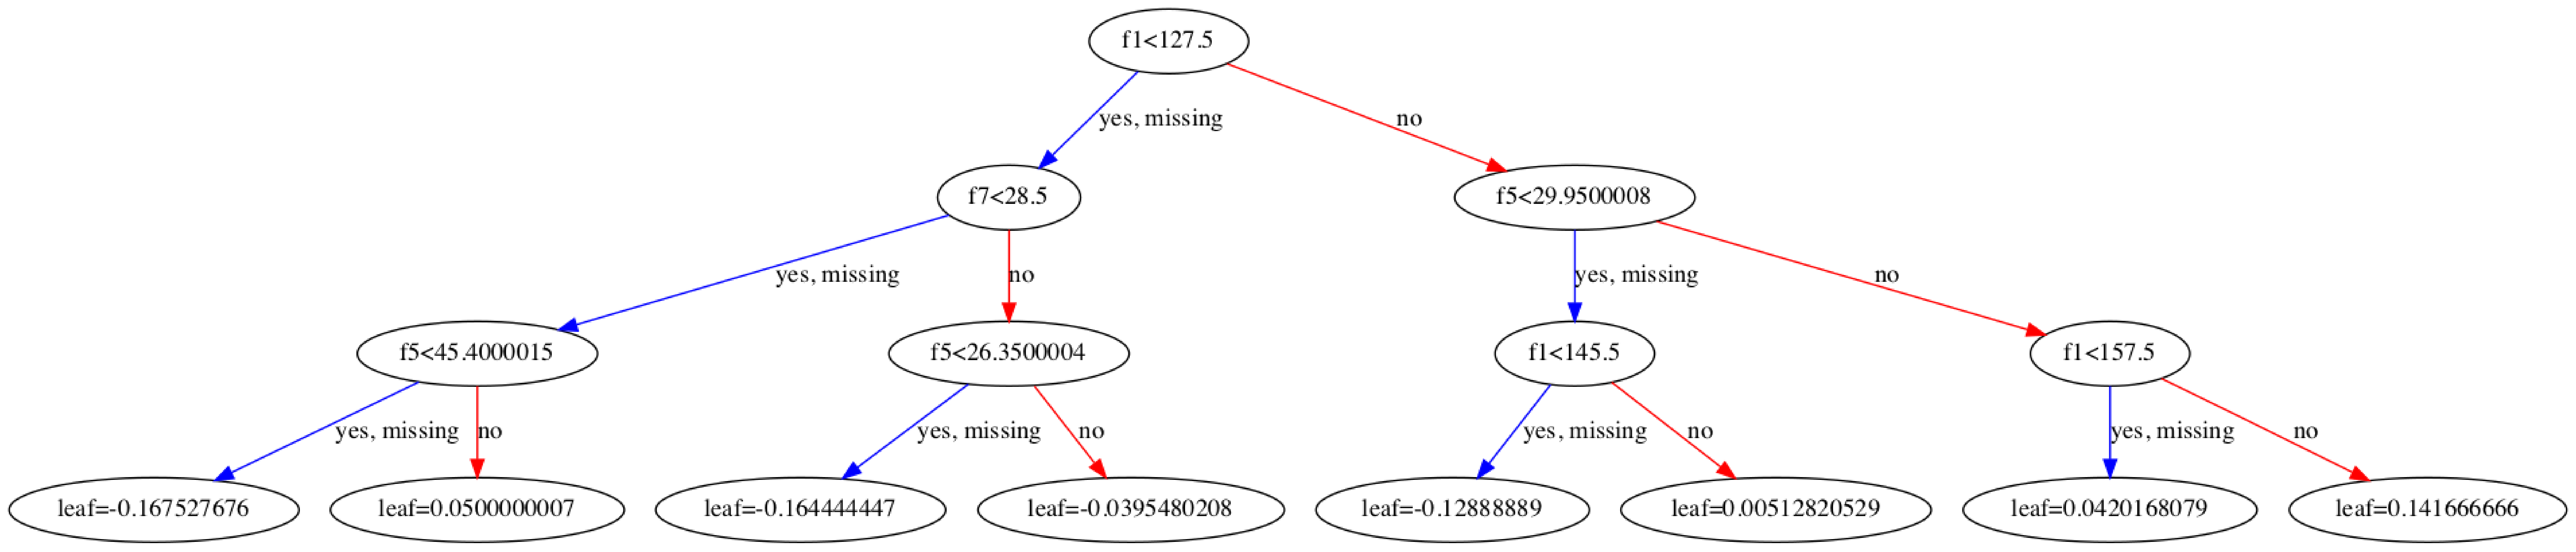

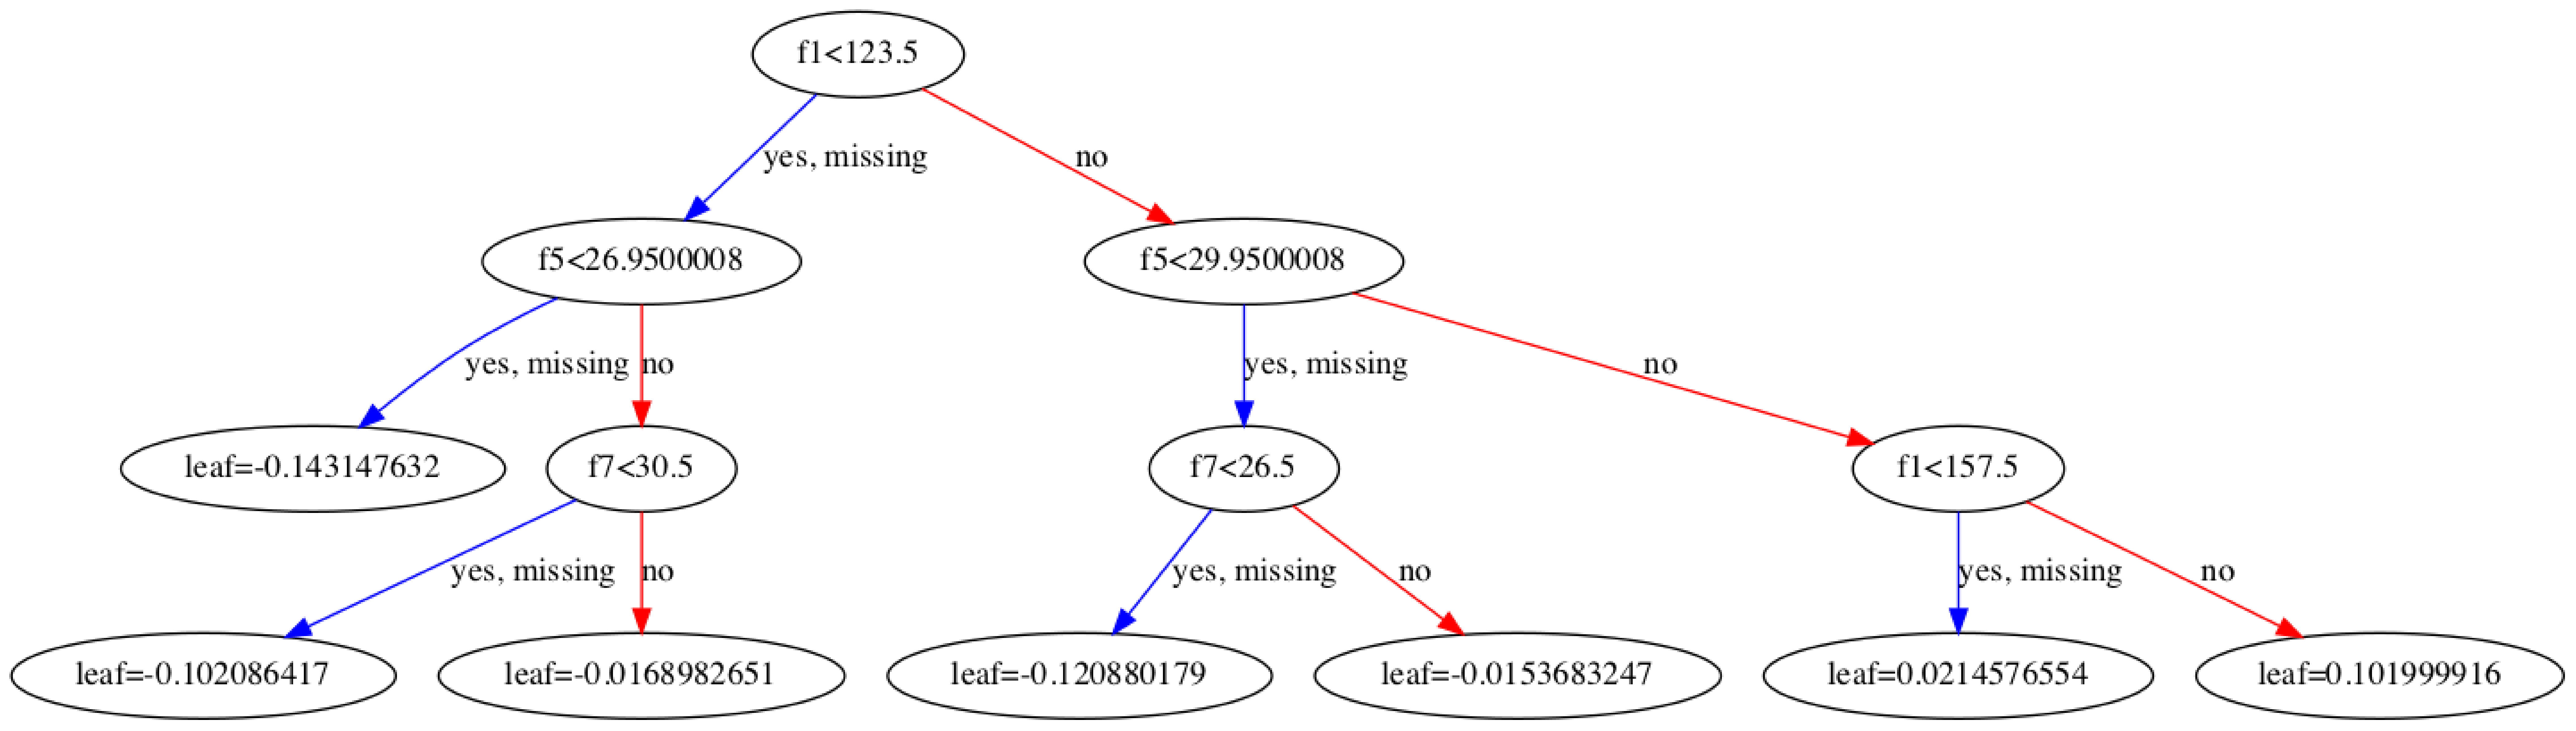

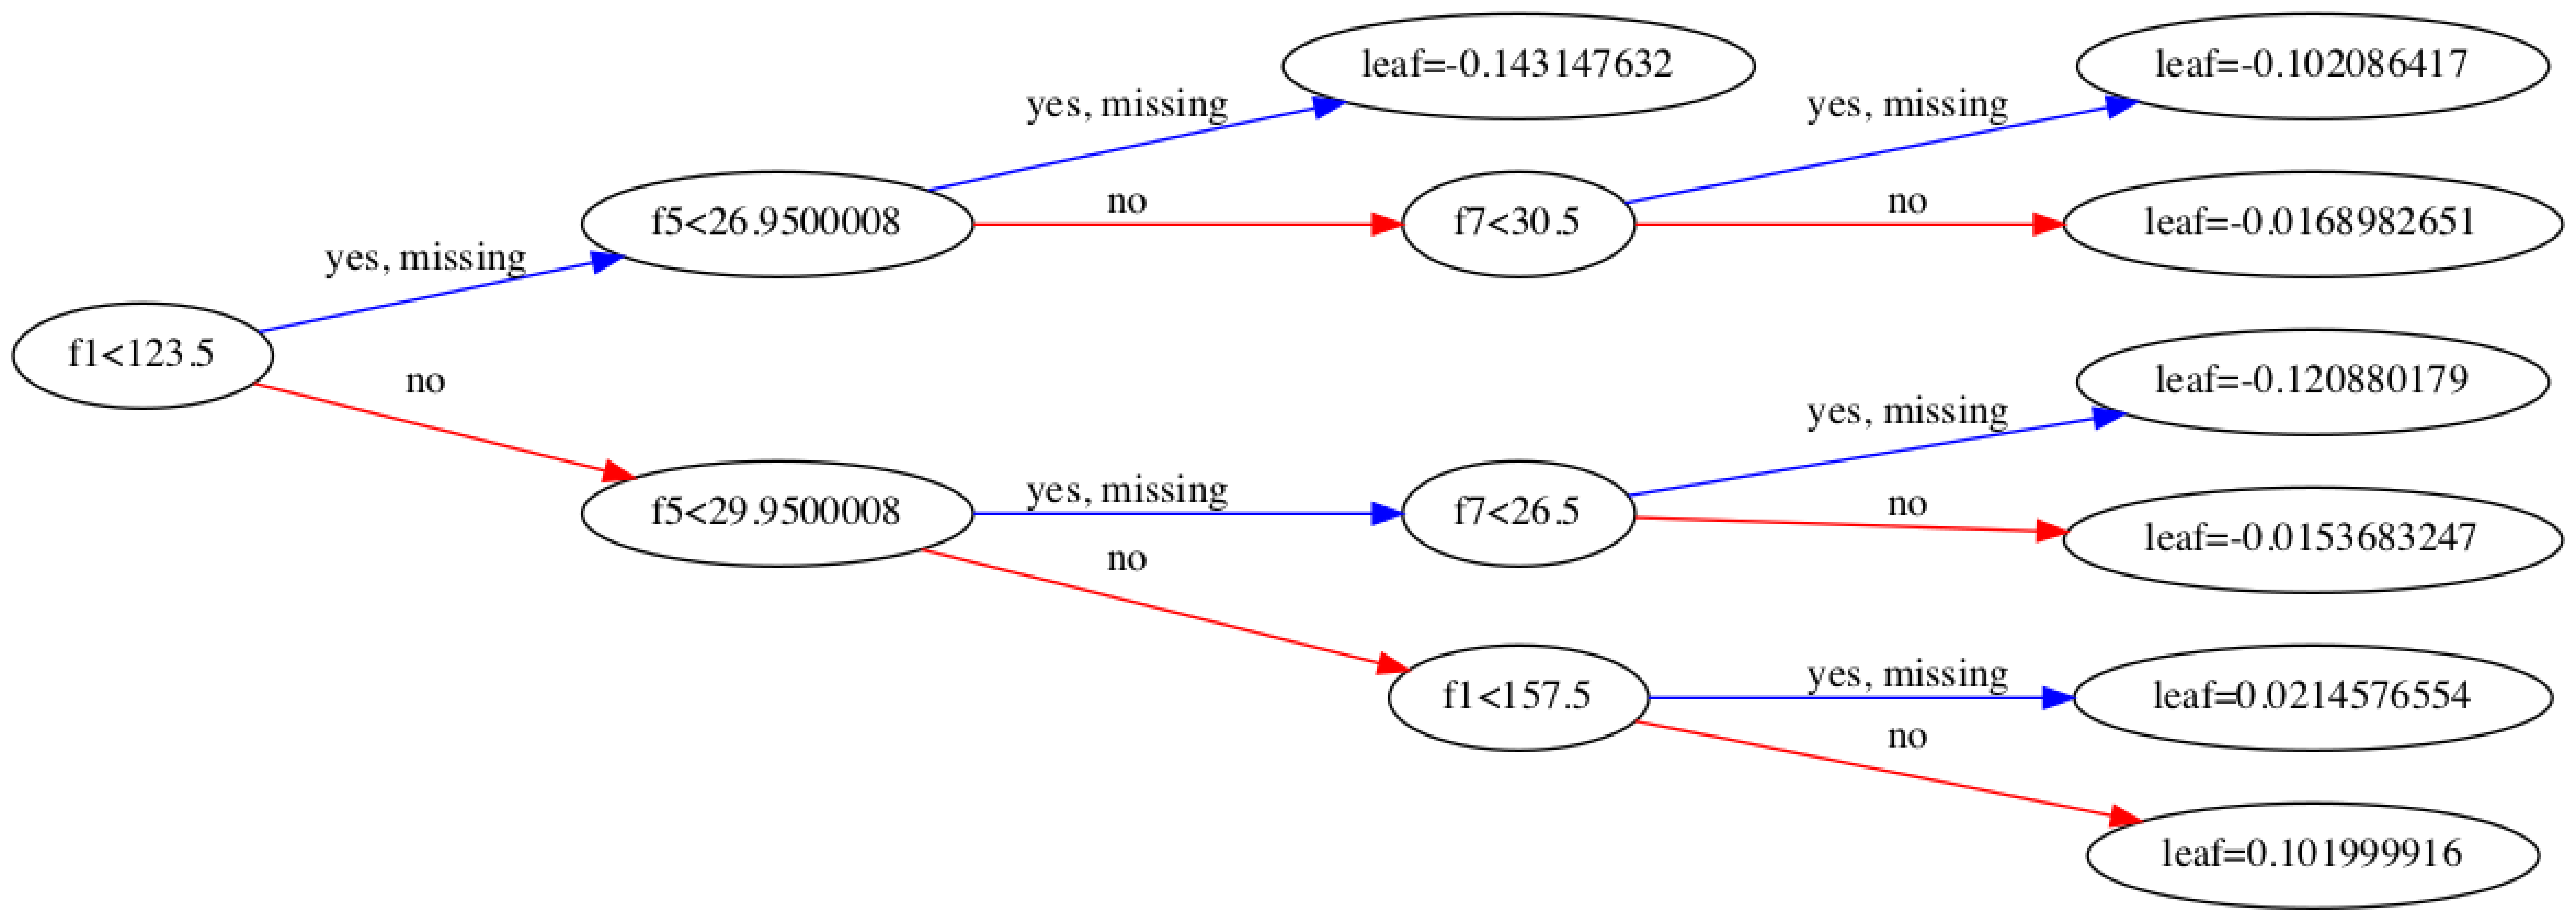

In [7]:
# Plotting a tree

# ! pip install graphviz

from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 150,150


model=XGBClassifier()

model.fit(X,y)

#plotting the first tree
xgb.plot_tree(model)

#plotting the fourth tree
xgb.plot_tree(model, num_trees=4)

#plotting from left to right 
xgb.plot_tree(model, num_trees=4, rankdir="LR")

#fig = plt.gcf()
#fig.set_size_inches(150, 150)
#fig.savefig('xgb_tree.png')


# Feature Importance

Similar to the Random Forest family we can obtain a vector with the relative importance of each feature and plot it.

<Figure size 1080x648 with 0 Axes>

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

pregnancies      0.0688
glucose          0.2879
pressure         0.0794
skin             0.0822
insulin          0.0832
bmi              0.1827
pedi             0.0925
age              0.1233


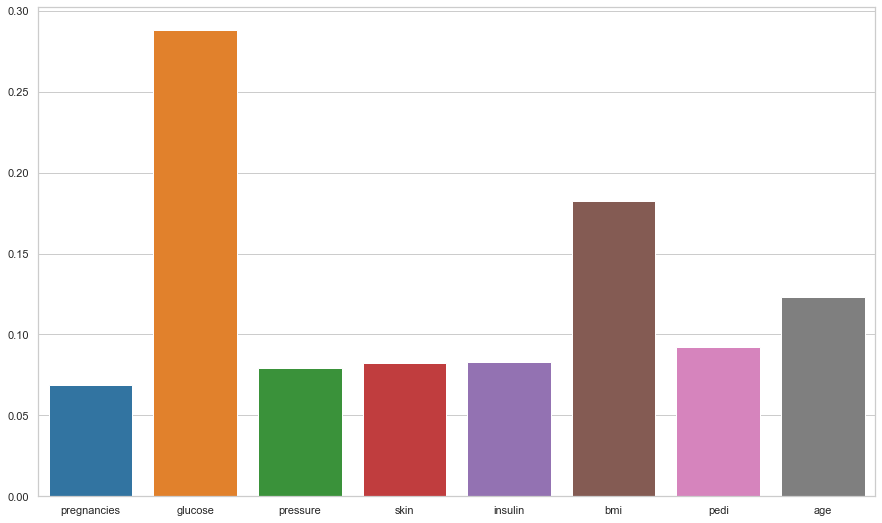

In [8]:
# XGBoost - Feature importance


y_p=p_indians["outcome"]
X_p=p_indians.drop(["outcome"],axis=1)


# create a train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size=0.4, random_state=7)

plt.figure(figsize=(15,9))

seed=7

model=XGBClassifier()
model.fit(X_train,y_train)

# Feature importance is calculated as the decrease in node impurity 
# weighted by the probability of reaching that node. 
# The node probability can be calculated by the number of samples that reach the node, 
# divided by the total number of samples. The higher the value the more important the feature.

for name, importance in zip(p_indians.columns, model.feature_importances_):
    print(f'{name:15s}  {importance:.4f}')

sns.barplot(x=p_indians.columns[:-1], y=model.feature_importances_)


[0]	test-logloss:0.643018
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.506988
[200]	test-logloss:0.479592


/Users/alfred/Documents/anaconda/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[242]	test-logloss:0.475786



Text(0.5, 1.0, 'xgboost.plot_importance(model)')

Weight. The number of times a feature is used to split the data across all trees.


Text(0.5, 1.0, "xgboost.plot_importance(model, importance_type='cover')")

Text(0.5, 1.0, "xgboost.plot_importance(model, importance_type='gain')")

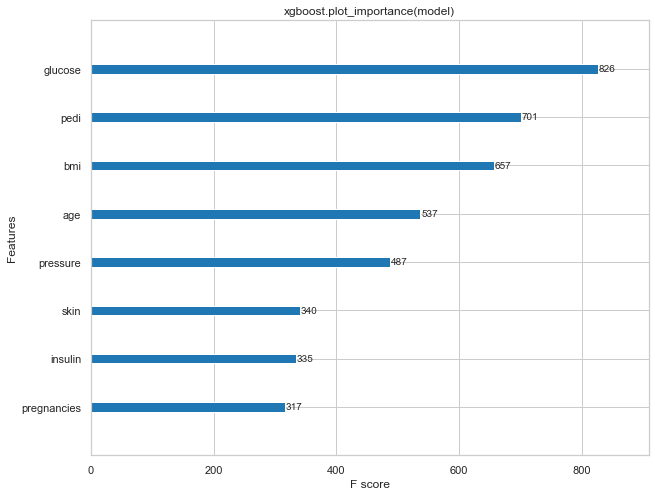

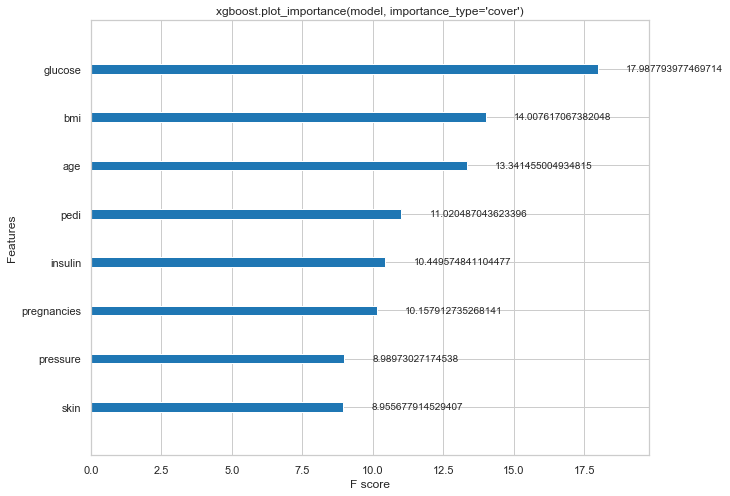

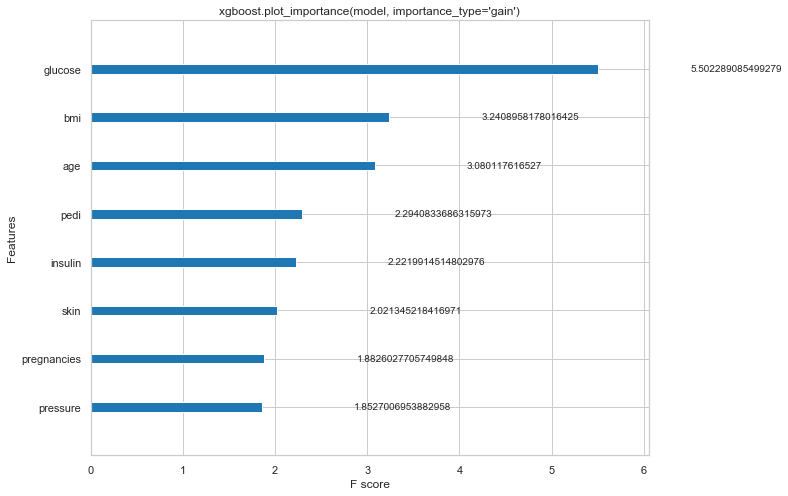

In [9]:
import matplotlib.pylab as pl

y_p=p_indians["outcome"]
X_p=p_indians.drop(["outcome"],axis=1)


# create a train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size=0.4, random_state=7)
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)


params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgb.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

# Weight. The number of times a feature is used to split the data across all trees.

ax=xgb.plot_importance(model, importance_type="weight")
pl.title("xgboost.plot_importance(model)")

print(f'Weight. The number of times a feature is used to split the data across all trees.')

ax.figure.set_size_inches(10,8)

# Cover. The number of times a feature is used to split the data across all trees 
#        weighted by the number of training data points that go through those splits.

ax=xgb.plot_importance(model, importance_type="cover")
pl.title("xgboost.plot_importance(model, importance_type='cover')")

ax.figure.set_size_inches(10,8)

# Gain. The average training loss reduction gained when using a feature for splitting.

ax=xgb.plot_importance(model, importance_type="gain")
pl.title("xgboost.plot_importance(model, importance_type='gain')")

ax.figure.set_size_inches(10,8)

# Tuning XGBoost

As any other Ensemble algorith, XGBoost and in general Gradient Boosting machines can be tuned, improving their performance subtantially. 

However, it has been an intense effort in this algorithms in order to have highly accurate default parameters. Therefore, you may think twice before engaging into tuning. Again, as any ensemble algorithm hyperparameter tuning can be expensive in terms of computational resources and you think of using a cloud platfrom for it. 

In its simplest version, there are three main parameters that you might want to explore:
<blockquote>
    <ul>
        <li>The number of Decision Trees. The default is a conservative 100. </li>
        <li>The size of the Decision Trees. Default is 3. </li>
        <li>The learning rate.</li>
    </ul>
</blockquote>
    

# Tuning the number of Decision Trees

Grid Best Score -0.4798774 N. of estimators  50

N. estimators  10 mean logloss -0.5311961 (0.00458)
N. estimators  25 mean logloss -0.4878734 (0.01583)
N. estimators  50 mean logloss -0.4798774 (0.02576)
N. estimators 100 mean logloss -0.4929980 (0.03561)
N. estimators 150 mean logloss -0.5110630 (0.04231)
N. estimators 200 mean logloss -0.5330653 (0.04984)
N. estimators 250 mean logloss -0.5595891 (0.05116)
N. estimators 300 mean logloss -0.5837842 (0.06064)


/Users/alfred/Documents/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<Figure size 1080x648 with 0 Axes>

Text(0.5, 1.0, 'N. estimators & Logloss')

Text(0.5, 0, 'N. estimators')

Text(0, 0.5, 'Logloss')

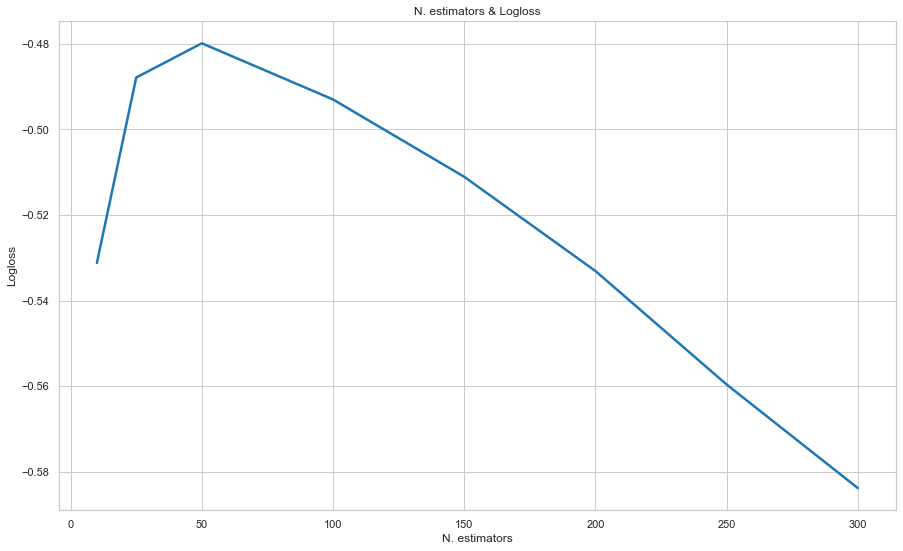

In [10]:
# XGBoost - Grid Search Parameter Tuning
#    

from sklearn.model_selection import GridSearchCV

seed=7

model = XGBClassifier()

kfold=StratifiedKFold(n_splits=3, random_state=seed)

param_grid={"n_estimators":[10, 25, 50, 100, 150, 200, 250, 300]}

grid=GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_log_loss", cv=kfold)
grid_result=grid.fit(X,y)

print(f'Grid Best Score {grid_result.best_score_:.7f} N. of estimators {grid_result.best_params_["n_estimators"]:3d}')
print()
      
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]      
params = grid_result.cv_results_["params"] 
      
for mean,std,param in zip(means,stds,params):
      print(f'N. estimators {param["n_estimators"]:3d} mean logloss {mean:.7f} ({std:.5f})')

plt.figure(figsize=(15,9))
sns.lineplot(x=param_grid["n_estimators"], y=means, linewidth=2.5)
plt.title("N. estimators & Logloss")
plt.xlabel("N. estimators")
plt.ylabel("Logloss")



# Tuning the size of the Decision Trees

Grid Best Score 0.7760417 Max Depth of Decision Trees   3

N. estimators   1 depth of Decision Tree 0.7630208 (0.01214)
N. estimators   2 depth of Decision Tree 0.7656250 (0.01874)
N. estimators   3 depth of Decision Tree 0.7760417 (0.03072)
N. estimators   4 depth of Decision Tree 0.7669271 (0.01688)
N. estimators   5 depth of Decision Tree 0.7578125 (0.02250)
N. estimators   6 depth of Decision Tree 0.7382812 (0.01069)
N. estimators   7 depth of Decision Tree 0.7473958 (0.01995)
N. estimators   8 depth of Decision Tree 0.7578125 (0.02155)
N. estimators   9 depth of Decision Tree 0.7460938 (0.01382)
N. estimators  10 depth of Decision Tree 0.7408854 (0.01975)


<Figure size 1080x648 with 0 Axes>

Text(0.5, 1.0, 'Depth of the Decision Trees & Accuracy')

Text(0.5, 0, 'Depth of the Decision Trees')

Text(0, 0.5, 'Accuracy')

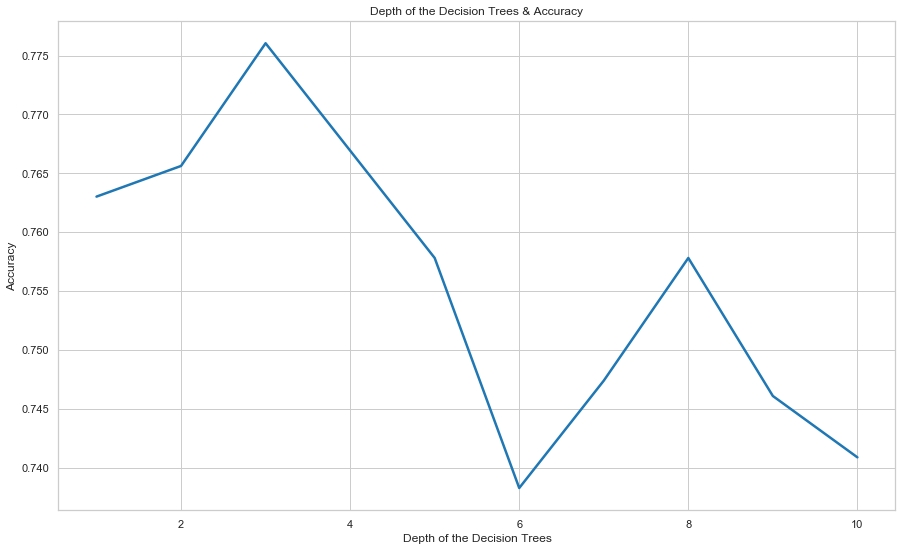

In [11]:
# XGBoost - Grid Search Parameter Tuning
#    

from sklearn.model_selection import GridSearchCV

seed=7

model = XGBClassifier()

kfold=StratifiedKFold(n_splits=3, random_state=seed)

param_grid={"max_depth":[1,2,3,4,5,6,7,8,9,10]}

grid=GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=kfold)
grid_result=grid.fit(X,y)

print(f'Grid Best Score {grid_result.best_score_:.7f} Max Depth of Decision Trees {grid_result.best_params_["max_depth"]:3d}')
print()
      
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]      
params = grid_result.cv_results_["params"] 
      
for mean,std,param in zip(means,stds,params):
      print(f'N. estimators {param["max_depth"]:3d} depth of Decision Tree {mean:.7f} ({std:.5f})')

plt.figure(figsize=(15,9))            
sns.lineplot(x=param_grid["max_depth"], y=means, linewidth=2.5)
plt.title("Depth of the Decision Trees & Accuracy")
plt.xlabel("Depth of the Decision Trees")
plt.ylabel("Accuracy")


# Tuning the number & size of the Decision Trees

Grid Best Score 0.7760417       Number of trees 100       Max Depth of Decision Trees   3

N. estimators  50             Depth   1 accuracy 0.7565104 (0.02316)
N. estimators 100             Depth   1 accuracy 0.7630208 (0.01214)
N. estimators 150             Depth   1 accuracy 0.7708333 (0.01981)
N. estimators 200             Depth   1 accuracy 0.7708333 (0.01849)
N. estimators 250             Depth   1 accuracy 0.7669271 (0.02001)
N. estimators 300             Depth   1 accuracy 0.7643229 (0.02166)
N. estimators  50             Depth   2 accuracy 0.7669271 (0.01683)
N. estimators 100             Depth   2 accuracy 0.7656250 (0.01874)
N. estimators 150             Depth   2 accuracy 0.7656250 (0.02463)
N. estimators 200             Depth   2 accuracy 0.7682292 (0.01691)
N. estimators 250             Depth   2 accuracy 0.7695312 (0.01043)
N. estimators 300             Depth   2 accuracy 0.7682292 (0.01411)
N. estimators  50             Depth   3 accuracy 0.7747396 (0.02351)
N. estimator

<Figure size 1080x648 with 0 Axes>

Text(0.5, 1.0, 'N. Estimators & Depth of the Decision Trees')

Text(0.5, 0, 'N. Estimators')

Text(0, 0.5, 'accuracy')

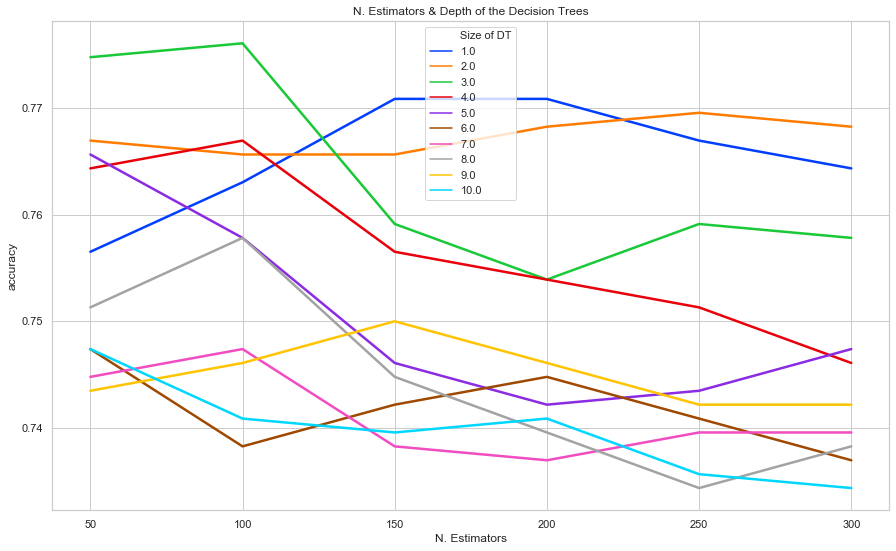

In [12]:
# XGBoost - Grid Search Parameter Tuning
#    

from sklearn.model_selection import GridSearchCV

seed=7

model = XGBClassifier()

kfold=StratifiedKFold(n_splits=3, random_state=seed)

param_grid={"max_depth":[1,2,3,4,5,6,7,8,9,10], "n_estimators":[50,100,150,200,250,300]}

grid=GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=kfold)
grid_result=grid.fit(X,y)

print(f'Grid Best Score {grid_result.best_score_:.7f} \
      Number of trees {grid_result.best_params_["n_estimators"]:3d} \
      Max Depth of Decision Trees {grid_result.best_params_["max_depth"]:3d}')
print()
      
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]      
params = grid_result.cv_results_["params"] 
      
tu_plot=pd.DataFrame(columns=["N estimators","Size of DT","accuracy"]) 
for mean,std,param in zip(means,stds,params):
    print(f'N. estimators {param["n_estimators"]:3d} \
            Depth {param["max_depth"]:3d} accuracy {mean:.7f} ({std:.5f})')
    tu_plot=tu_plot.append({"N estimators":param["n_estimators"],\
                            "Size of DT":param["max_depth"], "accuracy":mean}, ignore_index=True)

plt.figure(figsize=(15,9))
sns.lineplot(data=tu_plot, x=tu_plot["N estimators"], y=tu_plot["accuracy"], \
             hue=tu_plot["Size of DT"], legend="full", palette=sns.color_palette("bright") ,linewidth=2.5)
plt.title("N. Estimators & Depth of the Decision Trees")
plt.xlabel("N. Estimators")
plt.ylabel("accuracy")
            